In [1]:
!pip install pymc
!pip install arviz


In [3]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [4]:
dados = pd.read_excel('/content/Consumo.xlsx')
#Exibe as cinco primeiras linhas
dados.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [5]:

X = dados[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']]
y = dados['mpg'].values

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo Bayesiano
with pm.Model() as modelo:
    # Priors para os coeficientes
    intercepto = pm.Normal('intercepto', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X_scaled.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Regressão linear
    mu = intercepto + pm.math.dot(X_scaled, betas)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Amostragem com NUTS
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Resumo dos resultados
az.summary(trace, var_names=['intercepto', 'betas', 'sigma'])

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercepto,23.439,0.168,23.123,23.761,0.002,0.003,4686.0,2488.0,1.0
betas[0],-0.613,0.449,-1.413,0.283,0.007,0.008,3645.0,2567.0,1.0
betas[1],0.641,0.575,-0.394,1.775,0.010,0.010,3405.0,2942.0,1.0
betas[2],-0.881,0.446,-1.721,-0.049,0.007,0.007,3630.0,3079.0,1.0
betas[3],-4.229,0.456,-5.094,-3.366,0.008,0.007,3408.0,2819.0,1.0
betas[4],-0.013,0.249,-0.470,0.464,0.004,0.004,3622.0,3237.0,1.0
betas[5],2.612,0.186,2.257,2.967,0.003,0.003,4385.0,2631.0,1.0
betas[6],1.074,0.215,0.634,1.439,0.003,0.003,4238.0,2827.0,1.0
sigma,3.315,0.118,3.104,3.541,0.002,0.002,4186.0,2947.0,1.0


array([[<Axes: title={'center': 'intercepto'}>,
        <Axes: title={'center': 'betas\n0'}>,
        <Axes: title={'center': 'betas\n1'}>,
        <Axes: title={'center': 'betas\n2'}>],
       [<Axes: title={'center': 'betas\n3'}>,
        <Axes: title={'center': 'betas\n4'}>,
        <Axes: title={'center': 'betas\n5'}>,
        <Axes: title={'center': 'betas\n6'}>]], dtype=object)

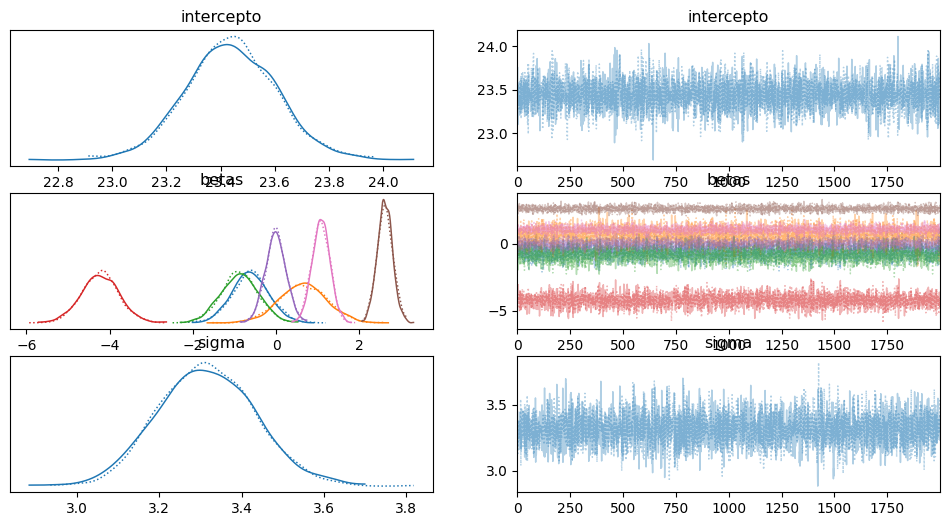

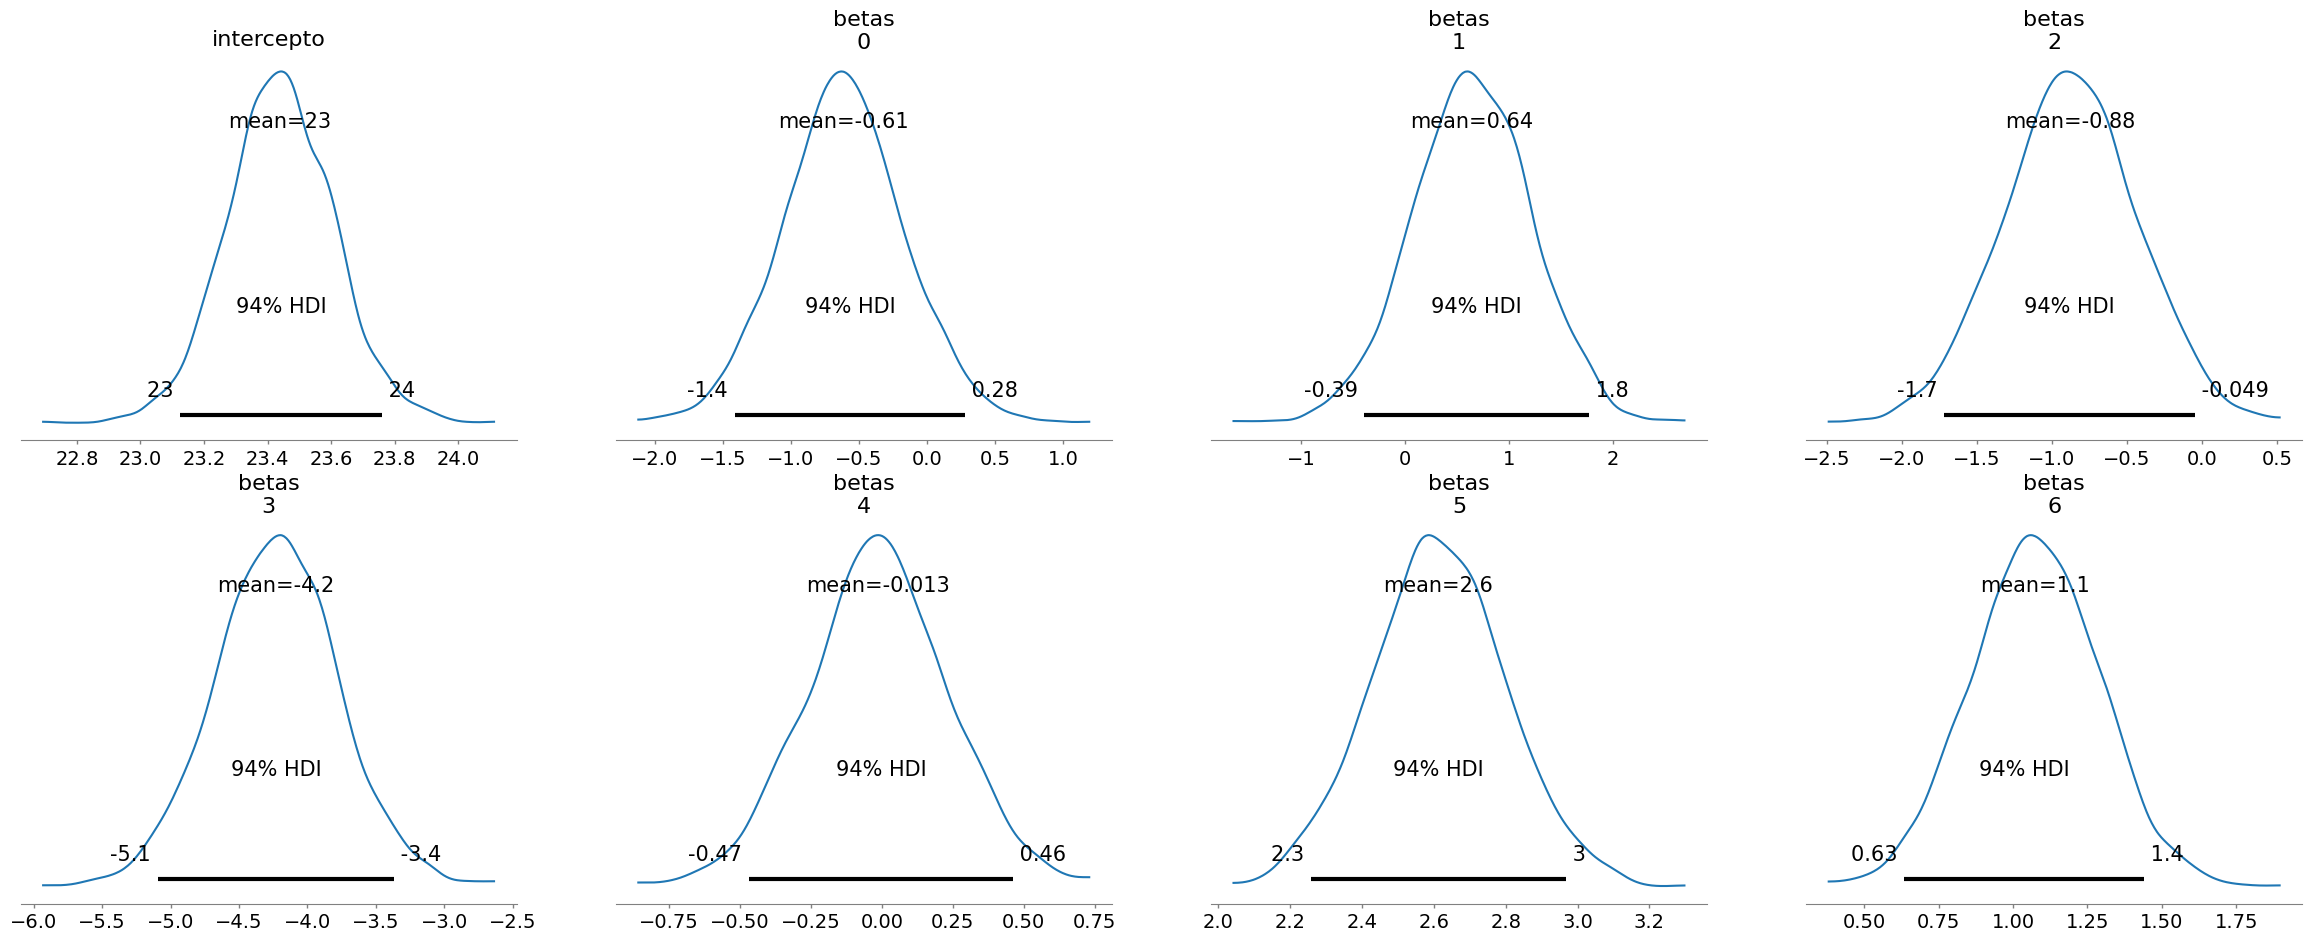

In [6]:
az.plot_trace(trace, var_names=['intercepto', 'betas', 'sigma'])
az.plot_posterior(trace, var_names=['intercepto', 'betas'])

In [8]:
# Lista com os nomes das variáveis
nomes_variaveis = X.columns.tolist()

# Obter o resumo dos betas
resumo_betas = az.summary(trace, var_names=['betas'])

# Adicionar os nomes das variáveis como índice
resumo_betas.index = nomes_variaveis

# Exibir o resumo com nomes legíveis
print(resumo_betas)

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cylinders    -0.613  0.449  -1.413    0.283      0.007    0.008    3645.0   
displacement  0.641  0.575  -0.394    1.775      0.010    0.010    3405.0   
horsepower   -0.881  0.446  -1.721   -0.049      0.007    0.007    3630.0   
weight       -4.229  0.456  -5.094   -3.366      0.008    0.007    3408.0   
acceleration -0.013  0.249  -0.470    0.464      0.004    0.004    3622.0   
year          2.612  0.186   2.257    2.967      0.003    0.003    4385.0   
origin        1.074  0.215   0.634    1.439      0.003    0.003    4238.0   

              ess_tail  r_hat  
cylinders       2567.0    1.0  
displacement    2942.0    1.0  
horsepower      3079.0    1.0  
weight          2819.0    1.0  
acceleration    3237.0    1.0  
year            2631.0    1.0  
origin          2827.0    1.0  


In [9]:
# Pegar y verdadeiro
y_true = y

# Obter predições da posterior (mu_pred tem shape: [n_obs, n_amostras])
posterior_betas = trace.posterior['betas'].stack(draws=("chain", "draw")).values
posterior_intercepto = trace.posterior['intercepto'].stack(draws=("chain", "draw")).values
mu_pred = posterior_intercepto + np.dot(X_scaled, posterior_betas)  # shape: [n_obs, n_amostras]

# R² para cada amostra da posterior
residuos = y_true[:, None] - mu_pred  # shape: [n_obs, n_amostras]
r2_amostral = 1 - (np.var(residuos, axis=0) / np.var(y_true))

# Estatísticas do R²
r2_medio = r2_amostral.mean()
r2_hdi = az.hdi(r2_amostral)

print(f"R² médio: {r2_medio:.3f}")
print(f"95% intervalo de credibilidade para R²: [{r2_hdi[0]:.3f}, {r2_hdi[1]:.3f}]")

R² médio: 0.816
95% intervalo de credibilidade para R²: [0.811, 0.820]
